In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
session

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
query = text("SELECT max(date) FROM measurement")
data = conn.execute(query)

for record in data:
    print(record)

('2017-08-23',)


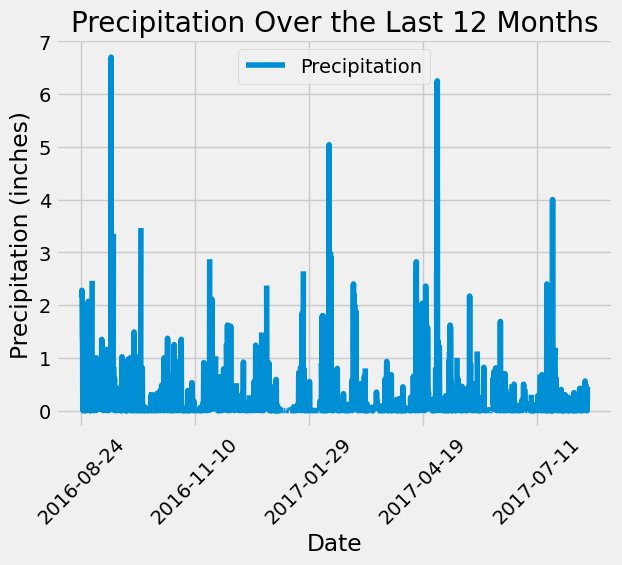

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurements_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Set the 'Date' column as the index
measurements_df.set_index('Date', inplace=True)

# Sort the dataframe by date
measurements_df = measurements_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
measurements_df.plot(rot=45)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = measurements_df.describe()
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station.station).count()
station_count

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station).label('count'))\
                        .group_by(measurement.station)\
                        .order_by(func.count(measurement.station).desc())\
                        .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# finding the most active station id
most_active_station_id = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()[0]

# calculating the lowest, hightes and average temps 
results = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station_id).all()

# assigning values to (names) to the results
lowest_temp = results[0][0]
highest_temp = results[0][1]
average_temp = results[0][2]

# printing the values print(f"Lowest Temperature: {lowest_temp}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


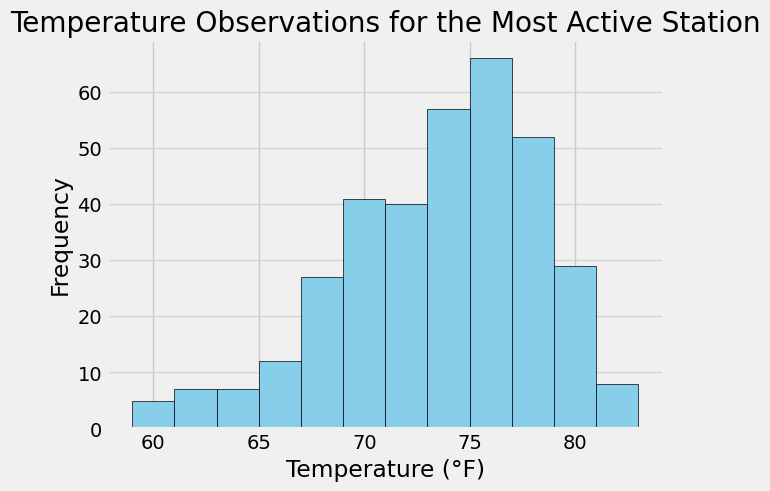

In [16]:

# Query the last 12 months of temperature data for the most active station
results = session.query(measurement.date, measurement.tobs)\
                .filter(measurement.station == most_active_station_id)\
                .filter(measurement.date >= one_year_ago)\
                .all()

# Extract dates and temperatures from the results
dates = [result[0] for result in results]
temperatures = [result[1] for result in results]

# Create the histogram plot
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Most Active Station')
plt.grid(axis='y', alpha=0.75)
plt.show()


# Close Session

In [17]:
# Close Session
session.close()